In [43]:
import time
import numpy as np
import pandas as pd
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from types import SimpleNamespace    
from collections import defaultdict
from ringity.network_models.param_utils import get_rate_parameter, interaction_strength_to_density

## Model parameters

In [2]:
N = 2**9

config_dict = {
    'default' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorterResponse' : {
        'c' : 1,
        'r' : 0.125,
        'beta' : 1,
        'rho' : None,
    },
    'longerResponse' : {
        'c' : 1,
        'r' : 0.5,
        'beta' : 1,
        'rho' : None,
    },
    'evenLongerResponse' : {
        'c' : 1,
        'r' : 0.75,
        'beta' : 1,
        'rho' : None,
    },
    'weakerInteraction' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorterDelay' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 0.75,
        'rho' : None,
    },
    'evenShorterDelay' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 0.5,
        'rho' : None,
    },
    'constantDensity' : {
        'c' : 0.075,
        'r' : None,
        'beta' : 1,
        'rho' : 0.025,
    },
    'random' : {
        'c' : np.random.uniform(),
        'r' : np.random.uniform(),
        'beta' : np.random.uniform(),
        'rho' : None,
    },
    'random_rho' : {
        'c' : np.random.uniform(),
        'r' : None,
        'beta' : np.random.uniform(),
        'rho' : np.random.uniform(),
    }
}

In [3]:
configuration = 'default'

beta = config_dict[configuration]['beta']
r = config_dict[configuration]['r']
c = config_dict[configuration]['c']
rho = config_dict[configuration]['rho']

In [4]:
param = SimpleNamespace(**config_dict[configuration])

## Calculations

In [5]:
G, pos = rng.network_model(N=N, c=c, r=r, beta=beta, return_positions=True, verbose=True)

Response parameter was calculated as: r = 0.25
Rate parameter was calculated as:   lambda = 0.0
Coupling parameter was calculated as: c = 1
Response parameter was calculated as: r = 0.25
Rate parameter was calculated as:   lambda = 0.0
Coupling parameter was calculated as: c = 1


In [6]:
rate = get_rate_parameter(beta=beta, rate = None)

In [7]:
rho_obs = nx.density(G)
rho_exp = interaction_strength_to_density(c=c, r=r, beta=beta)
score = rng.ring_score(G)

In [8]:
print(f"rho_obs = {rho_obs:.3f}")
print(f"rho_exp = {rho_exp:.3f}")
print(f"score   = {score:.3f}")

rho_obs = 0.250
rho_exp = 0.250
score   = 0.991
rho_obs = 0.250
rho_exp = 0.250
score   = 0.991


In [9]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

## Interaction function

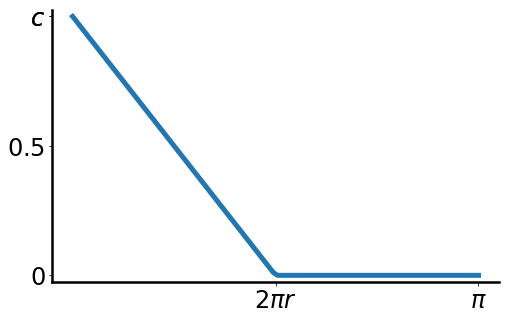

In [10]:
x = np.linspace(0, np.pi, 100)
y = c*(1-x/(2*np.pi*r)).clip(0)

fig_func, ax = plt.subplots(figsize = (8,5))

ax.plot(x, y, linewidth = 5)


plt.xticks([2*np.pi*r, np.pi], [r'$2\pi r$', r'$\pi$'])
plt.yticks([0, 0.5, 1, c], [r'$0$', r'$0.5$', r'$1$', r'$c$'])

ax.set_ylim(-0.025, 1.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Network visualization

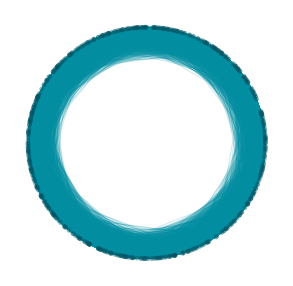

In [11]:
netviz_circ_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = circ_layout)

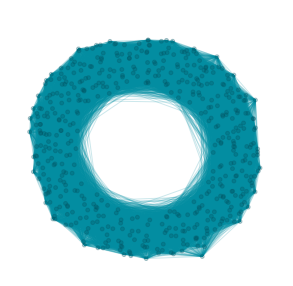

In [12]:
netviz_spri_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = spring_layout)

## ring-score distribution

In [14]:
N_list = [2**k for k in range(7, 10)]

In [ ]:
n_ensemble = 2**4
N_list = [2**k for k in range(5, 12)]
score = defaultdict(list)

t1 = time.time()
for N in N_list:
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, c=c, r=r, beta=beta)
        score[N].append(rng.ring_score(G))
        
t2 = time.time()

print(t2 - t1)

In [48]:
plot_df = pd.melt(pd.DataFrame(score))

<AxesSubplot:xlabel='variable', ylabel='value'>

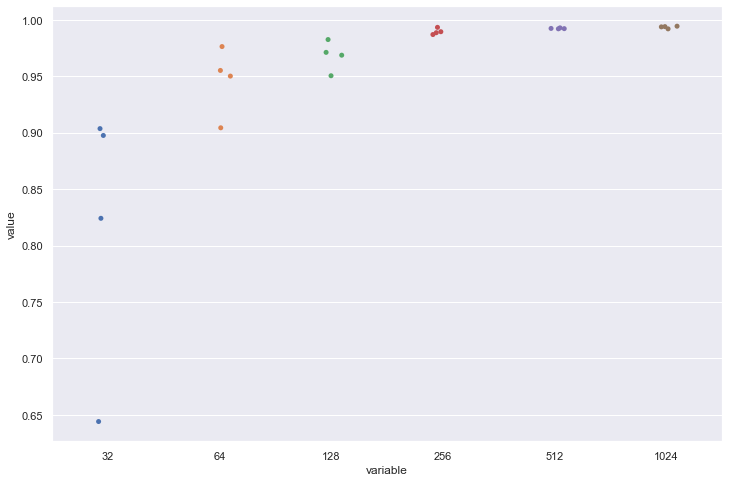

In [57]:
fig, ax = plt.subplots(figsize = (12,8))
sns.stripplot(x = "variable", y = "value", data = plot_df, ax=ax)

## Clustering coefficient

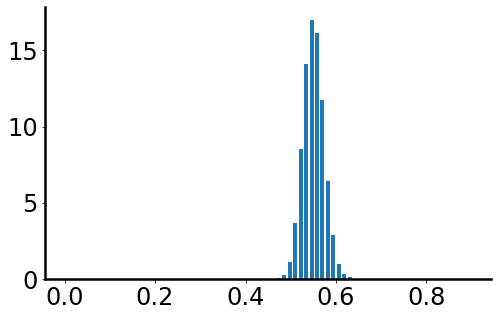

In [13]:
clust = []

for _ in range(2**6):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    clust.extend(rng.clustering_coefficient(G))

clust_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=75, range=(0, 0.9), 
        rwidth = 0.75, density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Degree distribution

In [15]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if np.isclose(rate, np.inf):
        A = 1/(2*np.pi*a)
        B = A*np.pi
        C = B - 1
        return np.clip(np.abs(A*theta - B) - C, 0, 1)
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

In [16]:
degs_exp = [p for theta in pos for p in np.random.binomial(N-1, c*expected_conditional_similarity(theta=theta, rate=rate, a=r), size=2**10)]

In [17]:
degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

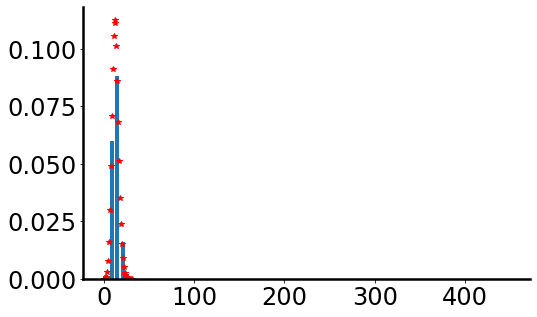

In [18]:
degs = []

for _ in range(2**6):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

deg_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 75, range = (0, 450),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xlabel('degree', fontsize=24)
#ax.set_ylabel('frequency', fontsize=18)

rng.ax_setup(ax)

## Save data

In [19]:
fig_func.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_interactionFunction.png")
fig_func.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_interactionFunction.pdf")

#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.png")
#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.pdf")

netviz_spri_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_spring.png")
netviz_spri_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_spring.pdf")

clust_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_clustering.png")
clust_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_clustering.pdf")

deg_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_degree.png")
deg_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_degree.pdf")

# Sandbox

In [62]:
N = 2**7
r = 0.25
c = 1
beta = 1

G = rng.network_model(N=N, c=c, r=r, beta=beta)
rng.ring_score(G)

0.9517653758012409

In [63]:
N = 2**8
r = 0.25
c = 1
beta = 1

G = rng.network_model(N=N, c=c, r=r, beta=beta)
rng.ring_score(G)

0.9784893774874269

In [64]:
N = 2**9
r = 0.25
c = 1
beta = 1

G = rng.network_model(N=N, c=c, r=r, beta=beta)
rng.ring_score(G)

0.9925229524422758

In [65]:
N = 2**10
r = 0.25
c = 1
beta = 1

G = rng.network_model(N=N, c=c, r=r, beta=beta)
rng.ring_score(G)

0.9927757185910315